# SDDP and newsvendor: the multi-commodity case

## Classic SDDP

In [1]:
using Distributions, JuMP, Gurobi, Plots, ProgressMeter, StatsBase
gurobi_env = Gurobi.Env()

Academic license - for non-commercial use only - expires 2021-11-06


Gurobi.Env(Ptr{Nothing} @0x0000000003843940, false, 0)

In [2]:
p = [1.0,2.0] #day ahead prices
q = [2.0,4.0] #same day price

#condicion inicial de stock
x0=[0.0,0.0];

$$V(x) = q \frac{(\theta-x)^2}{2\theta}$$

$$C(x) = px + V(x)$$

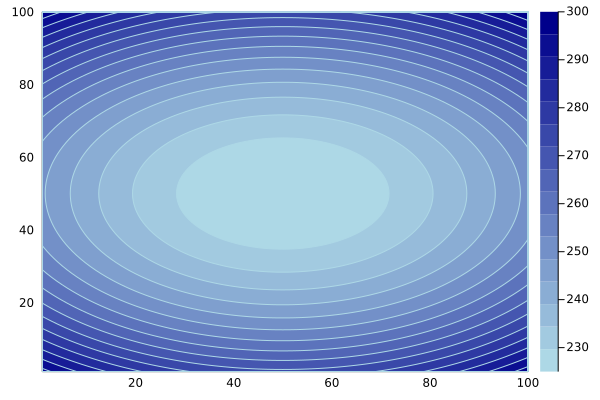

In [3]:
V(x,y) = q[1]*(100-x)^2/(2*100) + q[2]*(100-y)^2/(2*100)
C(x,y) = p[1]*x + q[1]*(100-x)^2/(2*100) + p[2]*y + q[2]*(100-y)^2/(2*100)

contour((1:100),(1:100),C, fill=true, c=:blues)

#cap = 50
#plot!([0,cap], [cap,0], lw=2, color=:red)

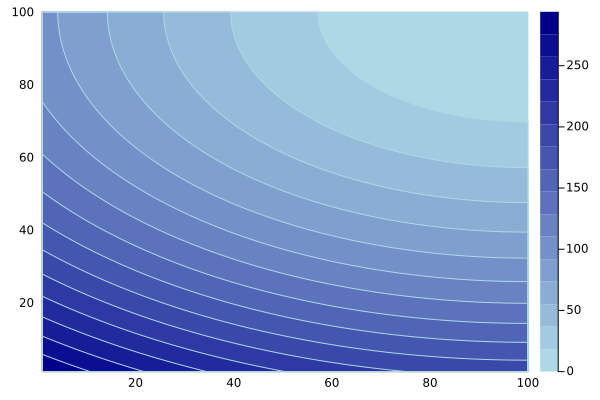

In [4]:
contour((1:100),(1:100),V, fill=true, c=:blues)


### Resuelvo por SDDP

In [5]:
#array de vectores de cuts. Arranca en la lower bound
#cuts = beta + lambda_1 x_1 + lambda_2 x_2 -> [beta,lambda1,lambda2]
cuts = [[0.0,0.0,0.0]];

niter=10

@showprogress for i=1:niter
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))
    @variable(model,reserve[1:2]>=0);
    @variable(model,stock[1:2]>=0);
    @variable(model,z);

    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2:3]'*(stock+reserve));
    end

    fix_x = @constraint(model,stock.==x0);

    #constraint de compra
    #@constraint(model,sum(reserve)<=cap)
    
    @objective(model,Min,p'*reserve+z);

    optimize!(model)

    x=value.(stock)+value.(reserve);

    #demand=rand(DiscreteUniform(0,100));
    #resuelvo para todos los ruidos el segundo paso y agrego un corte
    local_cuts = [];

    for demand1=0:100
        
        for demand2=0:100
    
            model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

            @variable(model,shortage[1:2]>=0);
            @variable(model,stock[1:2]>=0);

            fix_x = @constraint(model,x-[demand1,demand2]+shortage.>=0);

    #        fix_x = @constraint(model,stock==x);

            @objective(model,Min,q'*shortage);

            optimize!(model)

            beta = objective_value(model);
            lambda = -dual.(fix_x)

            push!(local_cuts,[beta-lambda'*x;lambda])
        end
    end

    new_cut = mean(local_cuts)
    push!(cuts,new_cut);
end

Progress: 100%|█████████████████████████████████████████| Time: 0:01:46


In [6]:
cuts

11-element Vector{Vector{Float64}}:
 [0.0, 0.0, 0.0]
 [300.0, -2.0, -4.0]
 [200.0, -0.0, -4.0]
 [227.22772277227722, -1.00990099009901, -2.01980198019802]
 [151.4851485148515, -0.0, -2.01980198019802]
 [135.14851485148515, -0.5148514851485149, -1.0297029702970297]
 [184.05940594059405, -0.5148514851485149, -1.7821782178217822]
 [187.12871287128712, -0.8910891089108911, -1.4257425742574257]
 [202.77227722772278, -0.7920792079207921, -1.7821782178217822]
 [210.27722772277227, -1.00990099009901, -1.702970297029703]
 [214.990099009901, -0.9306930693069307, -1.8613861386138615]

In [7]:
function piecewise_linear(x,cuts)
    aux = [cut[1] + cut[2:end]'*x for cut in cuts]
    return maximum(aux)
end

piecewise_linear (generic function with 1 method)

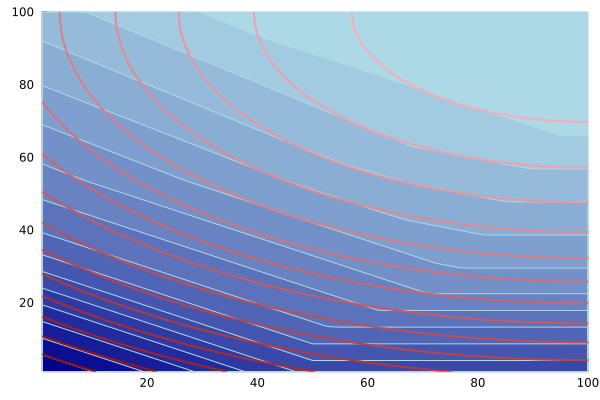

In [8]:
contour((1:100),(1:100),(x,y)-> piecewise_linear([x,y],cuts), fill=true, c=:blues, colorbar=:none)
contour!((1:100),(1:100),V, fill=false, c=:reds, lw=2, colorbar=:none, camera = (20, 20))


### Resuelvo el problema de stock

In [9]:
#resuelvo una vez mas para hallar el costo optimo
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env)))


@variable(model,reserve[1:2]>=0);
@variable(model,stock[1:2]>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2:3]'*(stock+reserve));
end

fix_x = @constraint(model,stock.==x0);

#constraint de compra
#@constraint(model,sum(reserve)<=cap)

@objective(model,Min,p'*reserve+z);

optimize!(model)

x=value.(stock)+value.(reserve);
costo = objective_value(model);
x, costo


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 13 rows, 5 columns and 49 nonzeros
Model fingerprint: 0xe360cdf5
Coefficient statistics:
  Matrix range     [5e-01, 4e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+02, 3e+02]
Presolve removed 3 rows and 2 columns
Presolve time: 0.00s
Presolved: 10 rows, 3 columns, 28 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.763089e+03   0.000000e+00      0s
       8    2.2569802e+02   0.000000e+00   0.000000e+00      0s

Solved in 8 iterations and 0.00 seconds
Optimal objective  2.256980198e+02

User-callback calls 36, time in user-callback 0.00 sec


([47.49999999999982, 53.49999999999999], 225.6980198019802)

## Stochastic cutting plane

In [21]:
#array de vectores de cuts. Arranca en la lower bound
cuts = [[0.0;0.0;0.0]];

#aca guardo solo los multiplicadores
duals = Vector{Vector{Float64}}(undef, 0)

#aca guardo los ruidos que fueron saliendo
noises = Vector{Vector{Float64}}(undef, 0)

#condicion inicial de stock
x0=[0.0,0.0]

2-element Vector{Float64}:
 0.0
 0.0

In [22]:
@showprogress 1 "Computing..." for l=1:1000
    #resuelvo el primer paso
    model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

    @variable(model,reserve[1:2]>=0);
    @variable(model,stock[1:2]>=0);
    @variable(model,z);

    for i=1:length(cuts)
        cut=cuts[i]
        @constraint(model,z>=cut[1]+cut[2:3]'*(stock+reserve));
    end

    fix_x = @constraint(model,stock.==x0);

    #constraint de compra
    #@constraint(model,sum(reserve)<=cap)
    
    @objective(model,Min,p'*reserve+z);

    optimize!(model)

    x=value.(stock)+value.(reserve);

    #resuelvo para un ruido en el segundo paso y agrego un corte
    demand=rand(DiscreteUniform(0,100),2);
    #demand=rand(Poisson(50),2);

    push!(noises,demand)

    local_cuts = [];

    for k=1:length(noises)

        model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env), "OutputFlag" => 0))

        @variable(model,shortage[1:2]>=0);
        @variable(model,stock[1:2]>=0);
        fix_x = @constraint(model,x-demand+shortage.>=0);

#        fix_x = @constraint(model,stock==x);

        @objective(model,Min,q'*shortage);

        optimize!(model)

        beta = objective_value(model);
        lambda = -dual.(fix_x)

        push!(local_cuts,[beta-lambda'*x;lambda])

    end


    #update all previous cuts for averaging
    for j=1:length(cuts)
        cuts[j] = (l-1)/l * cuts[j];
    end

    new_cut = mean(local_cuts)
    
    push!(cuts,new_cut);
    push!(duals,new_cut[2:3]);
    
end

Computing...100%|███████████████████████████████████████| Time: 0:05:46


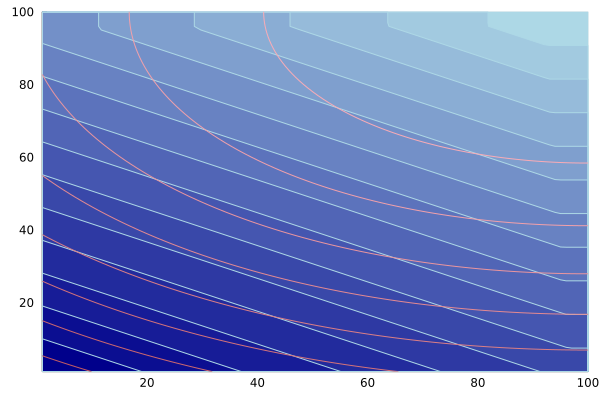

In [23]:
contour((1:100),(1:100),(x,y)-> piecewise_linear([x,y],cuts), fill=true, c=:blues, colorbar=:none)
contour!((1:100),(1:100),V, fill=false, c=:reds, colorbar=:none)

In [24]:
duals

1000-element Vector{Vector{Float64}}:
 [-2.0, -4.0]
 [-0.0, -4.0]
 [-2.0, -0.0]
 [-2.0, -0.0]
 [-2.0, -4.0]
 [-0.0, -0.0]
 [-0.0, -0.0]
 [-0.0, -0.0]
 [-2.0, -0.0]
 [-0.0, -4.0]
 [-2.0, -4.0]
 [-2.0, -0.0]
 [-2.0, -4.0]
 ⋮
 [-0.0, -0.0]
 [-0.0, -0.0]
 [-0.0, -0.0]
 [-0.0, -0.0]
 [-0.0, -0.0]
 [-0.0, -0.0]
 [-0.0, -0.0]
 [-0.0, -0.0]
 [-0.0, -0.0]
 [-2.0, -0.0]
 [-0.0, -0.0]
 [-0.0, -0.0]

### Resuelvo el problema de stock

In [25]:
#resuelvo una vez mas para hallar el costo optimo
model = JuMP.Model(optimizer_with_attributes(() -> Gurobi.Optimizer(gurobi_env)))


@variable(model,reserve[1:2]>=0);
@variable(model,stock[1:2]>=0);
@variable(model,z);

for i=1:length(cuts)
    cut=cuts[i]
    @constraint(model,z>=cut[1]+cut[2:3]'*(stock+reserve));
end

fix_x = @constraint(model,stock.==x0);

#constraint de compra
#@constraint(model,sum(reserve)<=cap)

@objective(model,Min,p'*reserve+z);

optimize!(model)

x=value.(stock)+value.(reserve);
costo = objective_value(model);
x, costo


Gurobi Optimizer version 9.1.2 build v9.1.2rc0 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1003 rows, 5 columns and 1465 nonzeros
Model fingerprint: 0xf78cb32d
Coefficient statistics:
  Matrix range     [2e-03, 4e+00]
  Objective range  [1e+00, 2e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e-01, 6e+02]
Presolve removed 794 rows and 2 columns
Presolve time: 0.00s
Presolved: 209 rows, 3 columns, 440 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.709627e+04   0.000000e+00      0s
       6    2.9912409e+02   0.000000e+00   0.000000e+00      0s

Solved in 6 iterations and 0.00 seconds
Optimal objective  2.991240896e+02

User-callback calls 35, time in user-callback 0.00 sec


([92.1906947255324, 96.02442952640617], 299.12408963147993)

## Stochastic Decomposition